In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.metrics import silhouette_score

# 1. Data preparation

### load data

In [409]:
df = pd.read_csv('./data/tasting_notes.csv')

In [410]:
df.head()

,Country,Company,Name,Aroma,Flavor,Color,Body
0,Germany,Spaten,Spaten Munich Helles Premium Lager,"toasty, hop","bitter, sweet, pomaceous fruit, floral",straw,3.0
1,Germany,Spaten,Spaten Oktoberfestbier,"sweet, caramel","citrus fruit, nutty",straw,4.0
2,Germany,Bitburger,Bitbruger Premium Pils,"grassy, pomaceous fruit, fresh","neat, hop, nutty, malty",gold,2.0
3,Germany,Hofbr?u M?nchen,Hofbr?u M?nchen Original Larger,"floral, sweet, malty","nutty, malty, bitter, sweet",gold,3.0
4,Germany,Weltenburger,Weltenburger Barock Dunkel,"roasty, malty, hop","sweet, toasty",brown,3.0


### drop all rows with NaN in 'Body' column

In [411]:
df = df[df['Body'].notna()]

In [412]:
len(df)

92

### split string in ['Aroma', 'Flavor'] into words

In [413]:
data = {'Aroma': [], 'Flavor': []}
for row in df[data.keys()].iterrows():
    _, (aroma, flavor) = row
    data['Aroma'] += [x.strip().replace(' ', '_') for x in aroma.split(',')]
    data['Flavor'] += [x.strip().replace(' ', '_') for x in flavor.split(',')]

### remove words with less than 6 counts

In [414]:
# convert list to Pandas Series and count unique values
data = {k: pd.Series(v).value_counts() for k, v in data.items()}

# remove words with less than 3 counts
data = {k: v.loc[v >= 6].index.values for k, v in data.items()}

### add two characteristics (Color, Body)

In [415]:
data['Color'] = ['straw', 'gold', 'amber', 'brown', 'black']
data['Body'] = ['light', 'light_medium', 'medium', 'medium_heavy', 'heavy']

In [416]:
data

{'Aroma': array(['sweet', 'citrus_fruit', 'spicy', 'pomaceous_fruit', 'banana',
        'fruity', 'caramel', 'hop', 'dried_fruit', 'malty', 'fresh',
        'roasty', 'citrus', 'berry', 'grassy'], dtype=object),
 'Flavor': array(['sweet', 'citrus_fruit', 'bitter', 'caramel', 'nutty', 'hop',
        'spicy', 'citrus', 'fruity', 'fresh', 'pomaceous_fruit', 'roasty',
        'toasty', 'smoky', 'dried_fruit', 'bready', 'malty', 'berry'],
       dtype=object),
 'Color': ['straw', 'gold', 'amber', 'brown', 'black'],
 'Body': ['light', 'light_medium', 'medium', 'medium_heavy', 'heavy']}

### concat all characteristics into one list

In [418]:
columns = []
for k, v in data.items():
    k = k.lower()
    columns += [f'{k}_{x}' for x in list(v)]
columns = np.array(columns)

### make new DataFrame
(index: beer names, rows: binary values, columns: characteristics)

In [419]:
mat = []
for _, row in df[['Aroma', 'Flavor', 'Color', 'Body']].iterrows():
    new_row = np.zeros(len(columns), dtype=np.int32)
    
    targets = []
    for k, v in row.iteritems():
        k = k.lower()
        if k == 'aroma' or k == 'flavor':
            targets += [f"{k}_{x.strip().replace(' ', '_')}" for x in v.split(',')]
        elif k == 'color':
            targets += [f'{k}_{v.strip()}']
        else:
            v = data['Body'][int(v) - 1]
            targets += [f'{k}_{v}']
    
    for t in targets:
        target_idx = np.where(columns == t)[0]
        new_row[target_idx] = 1
    
    mat.append(new_row)
    
mat = np.array(mat, dtype=np.int32)

In [420]:
df2 = pd.DataFrame(data=mat, columns=columns, index=pd.Index(df['Name'], name='Name'))

In [421]:
df2.head()

,aroma_sweet,aroma_citrus_fruit,aroma_spicy,aroma_pomaceous_fruit,aroma_banana,aroma_fruity,aroma_caramel,aroma_hop,aroma_dried_fruit,aroma_malty,...,color_straw,color_gold,color_amber,color_brown,color_black,body_light,body_light_medium,body_medium,body_medium_heavy,body_heavy
Name,,,,,,,,,,,,,,,,,,,,,
Spaten Munich Helles Premium Lager,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
Spaten Oktoberfestbier,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
Bitbruger Premium Pils,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
Hofbr?u M?nchen Original Larger,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
Weltenburger Barock Dunkel,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0


# 2. Agglomerative clustering

### construct a distance matrix

In [422]:
dist_mat = pdist(df2, metric='jaccard')

In [423]:
dist_mat.shape

(4186,)

### construct clusters and plot dendrogram

In [424]:
clust = linkage(dist_mat, 'ward')

In [450]:
def plot_dendrogram(clust, labels, figsize, labelsize):
    plt.rcParams.update({"font.family" : "serif", "mathtext.fontset" : "stix"})
    plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    dendrogram(
        clust,
        color_threshold=1.15,
        orientation='right',
        labels=labels,
        ax=ax
    )
    ax.tick_params(axis='both', labelsize=labelsize)

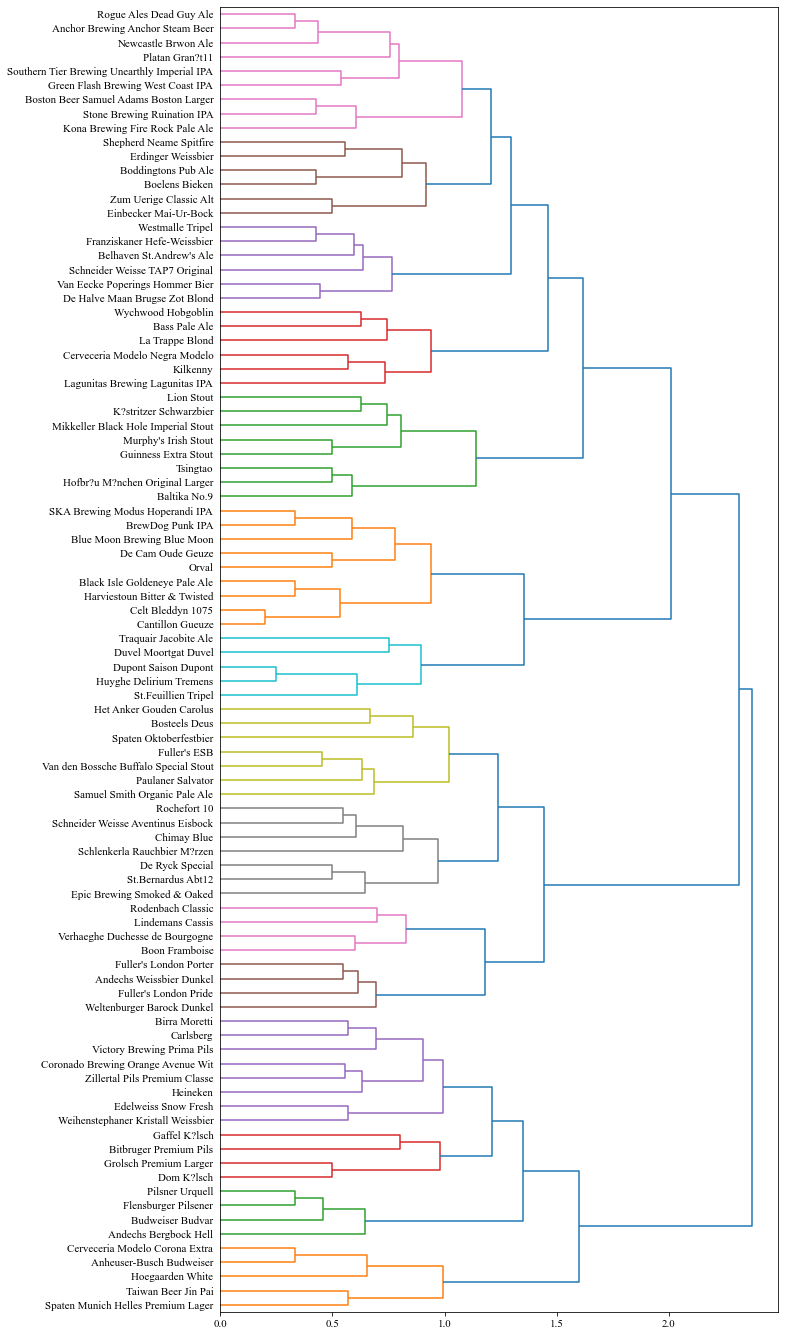

In [451]:
plot_dendrogram(clust, df2.index, (10, 24), 11)

### compute silhouette score and plot

In [427]:
# convert vector to square matrix
dist_mat = squareform(dist_mat)

scores = []
for i in range(2, 31):
    clust_labels = cut_tree(clust, i).reshape(-1)
    scores.append(silhouette_score(dist_mat, clust_labels, metric='precomputed'))

In [428]:
def plot_silhouette_score(scores, figsize):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    
    x = np.arange(2, 31)
    ax.scatter(x, scores)
    
    ax.set_xlabel('the number of clusters', fontsize=14, labelpad=10)
    ax.set_ylabel('silhouette score', fontsize=14, labelpad=10)

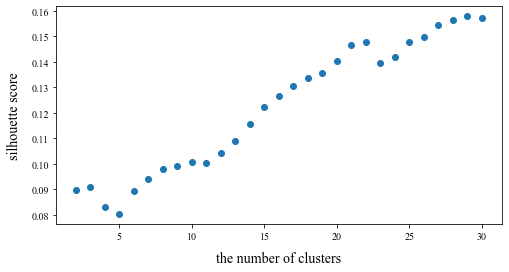

In [429]:
plot_silhouette_score(scores, (8, 4))

# 3. Get characteristics of each cluster

### cut tree to make 15 clusters

In [430]:
n_clusters = 15
clust_labels = cut_tree(clust, n_clusters).reshape(-1)

### get characteristics of each cluster

In [442]:
def get_each_cluster_characteristics(df, n_each_characteristic, clust_labels, count_thresh):
    
    beer_names = []
    characteristics = {'Aroma': [], 'Flavor': [], 'Color': [], 'Body': []}
    
    n_clusters = np.unique(clust_labels).shape[0]
    
    for clust_label in range(n_clusters):
        # select beers assigned to this cluster
        idx = np.where(clust_labels == clust_label)[0]
        counts = df2.iloc[idx].sum()
        
        # get name of beers in this cluster
        beer_names.append(', '.join(df.index[idx]))
        
        # get characteristic of this cluster
        n_total = 0
        for k, n in zip(characteristics.keys(), n_each_characteristic):
            if k == 'Aroma' or k == 'Flavor':
                target = np.where(counts[n_total:n_total + n ] >= count_thresh)[0]
            else:
                target = [np.argmax(counts[n_total:n_total + n]) + n_total]
            
            characteristic = []
            for c in df.columns[target]:
                splits = c.split('_')
                characteristic.append(' '.join(splits[1:]))
            
            characteristics[k].append(', '.join(characteristic))
            
            n_total += n
            
    characteristics['Name'] = beer_names
    
    characteristics = pd.DataFrame(characteristics, index=pd.Index(np.arange(1, n_clusters + 1)))
    characteristics = characteristics[['Name', 'Aroma', 'Flavor', 'Color', 'Body']]
    
    return characteristics

In [443]:
n_each_characteristic = [len(v) for v in data.values()]
df3 = get_each_cluster_characteristics(df2, n_each_characteristic, clust_labels, count_thresh=2)

In [444]:
df3.head()

,Name,Aroma,Flavor,Color,Body
1,"Spaten Munich Helles Premium Lager, Hoegaarden...","citrus fruit, hop",sweet,straw,light
2,"Spaten Oktoberfestbier, Paulaner Salvator, Bos...","sweet, pomaceous fruit, caramel, dried fruit, ...","sweet, citrus fruit, berry",brown,heavy
3,"Bitbruger Premium Pils, Dom K?lsch, Gaffel K?l...",fruity,fruity,gold,light medium
4,"Hofbr?u M?nchen Original Larger, K?stritzer Sc...","sweet, roasty","sweet, spicy, banana, roasty, citrus fruit",black,medium
5,"Weltenburger Barock Dunkel, Andechs Weissbier ...","sweet, roasty","sweet, pomaceous fruit, roasty, citrus",brown,medium


### save results

In [445]:
df3.to_csv('clusters.csv', index=False)

In [435]:
df['Cluster'] = clust_labels
df = df.sort_values(by='Cluster')
df.to_csv('results.csv', index=False)